2017-02-14 15:07:48.585574 3.0
2017-02-14 15:07:48.657571 3.07070707071
2017-02-14 15:07:48.711907 3.14141414141
2017-02-14 15:07:48.766349 3.21212121212
2017-02-14 15:07:48.821656 3.28282828283
2017-02-14 15:07:48.876353 3.35353535354
2017-02-14 15:07:48.930751 3.42424242424
2017-02-14 15:07:48.983616 3.49494949495
2017-02-14 15:07:49.037904 3.56565656566
2017-02-14 15:07:49.096202 3.63636363636
2017-02-14 15:07:49.154233 3.70707070707
2017-02-14 15:07:49.209133 3.77777777778
2017-02-14 15:07:49.264142 3.84848484848
2017-02-14 15:07:49.318134 3.91919191919
2017-02-14 15:07:49.371713 3.9898989899
2017-02-14 15:07:49.427262 4.06060606061
2017-02-14 15:07:49.481504 4.13131313131
2017-02-14 15:07:49.535990 4.20202020202
2017-02-14 15:07:49.590292 4.27272727273
2017-02-14 15:07:49.643591 4.34343434343
2017-02-14 15:07:49.697332 4.41414141414
2017-02-14 15:07:49.749833 4.48484848485
2017-02-14 15:07:49.804191 4.55555555556
2017-02-14 15:07:49.858164 4.62626262626
2017-02-14 15:07:49.911788 

<IPython.core.display.Javascript object>


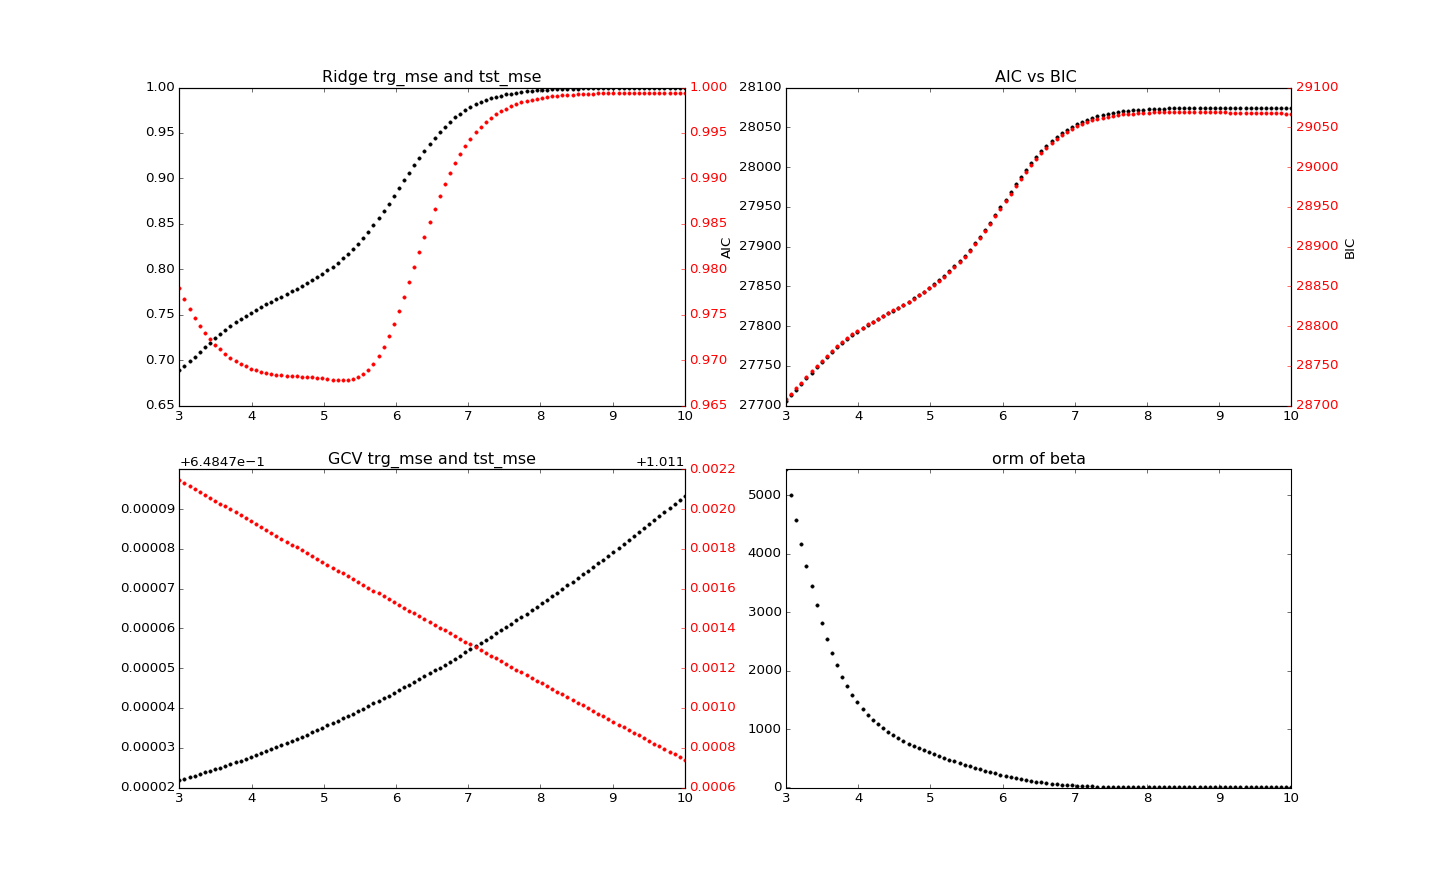

/home/ubuntu/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [43]:
%matplotlib nbagg

N = 1000
p1 = 10
p2 = 5

# tf.reset_default_graph()
# del sess
# sess = tf.InteractiveSession()
# g = tf.Graph().as_default()
# W1 = tf.Variable( randn(p1, p2 ) )
# W2 = tf.Variable( randn( p2, 1) )
# X = randn( N, p1 )
# h1 = tf.nn.relu( tf.matmul(X,  W1 ), name='h1' )
# y = tf.tanh ( tf.matmul(h1, W2), name='y') + randn(N,1)
# sess.run(tf.initialize_all_variables())
# y.eval()



def relu( x ):
    return x * (x > 0)

def I(x):
    return x

# build the true dataset
W1 = randn(p1, p2 )
W2 = randn( p2, 1) 

Z_trg = randn( N, p1 )
y_trg = I ( exp( Z_trg @ W1 ) @ W2 ) + randn(N,1)
Z_tst = randn( N, p1 )
y_tst = I ( exp( Z_tst @ W1 ) @ W2 ) + randn(N,1)

def evaluate(yhat_trg, yhat_tst):
    return norm( yhat_trg - y_trg ) ** 2 / norm(y_trg)**2,  norm( yhat_tst - y_tst ) ** 2 / norm(y_tst)**2


# build a larger (polynomial) feature space

def make_features(Z, po):
    return hstack( [ Z, Z**2, Z**3, Z**4, Z**5, Z**2/2+Z**3/6, Z@ W1, (Z@ W1)**2, randn(N, p1*p2*po) ] )
#     return hstack( [array( [ np.cos(Z[:,i]*p) for i in range(Z.shape[1]) for p in range(1, p1) ] ).T, 
#                     randn(N, p1)] )

X_trg = make_features(Z_trg, 3)
X_tst = make_features(Z_tst, 3)

# test simple ridge regression
from sklearn import linear_model

ridge = {}
alphas = linspace(3, 10, 100)
for alpha in alphas:
    print(dt.datetime.now(), alpha)
    reg = linear_model.Ridge (alpha = 10**alpha, fit_intercept=True)
    reg.fit( X_trg, y_trg )
    yhat_trg = reg.predict(X_trg);
    mse_trg, mse_tst = evaluate( yhat_trg, reg.predict(X_tst) )    
    beta_norm = norm( reg.coef_ )
    evs = linalg.eigvals( X_trg.T @ X_trg )
    df = np.sum( evs / (evs + alpha) )
    log_rss = log( norm( yhat_trg - y_trg ) ** 2  );
    aic =  X_trg.shape[0] * log_rss + 2 * df;
    bic =  X_trg.shape[0] * log_rss + df * log( X_trg.shape[0] );
    # do GCV
    reg_gcv = linear_model.RidgeCV( alphas=(alpha,), fit_intercept=True )
    reg_gcv.fit(X_trg, y_trg)
    mse_gcv_trg, mse_gcv_tst = evaluate( reg_gcv.predict(X_trg), reg_gcv.predict(X_tst) )    
    ridge[alpha] = ( mse_trg, mse_tst, aic, bic, mse_gcv_trg, mse_gcv_tst, beta_norm)

a, values = list(zip(*ridge.items()))
mse_trg, mse_tst, aic, bic,  mse_gcv_trg, mse_gcv_tst, beta_norm = list(zip(*values))
mse_gcv_trg = [ _ if isfinite( _ ) else 0 for _ in mse_gcv_trg ]
mse_gcv_tst = [ _ if isfinite( _ ) else 0 for _ in mse_gcv_tst ]

subplot(221);
plot( a, mse_trg, '.k', label='trg error')
gca().tick_params(axis='y', colors='black')
ax = gca().twinx()
ax.plot( a, mse_tst, '.r', label='tst error')
ax.tick_params(axis='y', colors='red')
#ax.set_ylim( (min(mse_trg+mse_tst)-0.1, max(mse_trg+mse_tst)+0.1) )
gca().set_title('Ridge trg_mse and tst_mse')

subplot(222);
gca().plot( a, aic, '.k', label='AIC')
gca().set_xlim((-1, alphas[-1]+1))
gca().set_ylabel('AIC')
ax = gca().twinx();
ax.plot( a, bic, '.r', label='BIC')
ax.set_ylabel('BIC')
ax.tick_params(axis='y', colors='red')
gca().set_title('AIC vs BIC ')


subplot(223);
plot( a, mse_gcv_trg, '.k', label='GCV trg error')
ax = gca().twinx();
ax.plot( a, mse_gcv_tst, '.r', label='GCV tst error')
ax.tick_params(axis='y', colors='red')
# gca().set_ylim( (min(mse_gcv_trg+mse_gcv_tst)-0.1, max(mse_gcv_trg+mse_gcv_tst)+0.1) )
gca().set_title('GCV trg_mse and tst_mse')


subplot(224);
plot( a, beta_norm, '.k', label='norm of beta')
gca().set_ylim( (min(beta_norm)-0.1, max(beta_norm)+0.1) )
gca().set_title('orm of beta')


# build a set of features

# yhat = 




In [1]:
# imports
from pandas import *
from pylab import *
import sys, os, re, importlib
print( 'running', sys.executable)
from importlib import reload
import tensorflow as tf
import tflearn as tfl
import numpy as np
import datetime as dt


running /home/ubuntu/anaconda3/bin/python


In [19]:
reg.coef_

array([[ -8.08970111,   2.5121652 ,   1.99017184,   2.24057081,
         -0.86046421,  -0.99573008,  -1.39874939,  -3.33376194,
         -4.24749028,   4.13114436,  -5.72936737,  -2.18832048,
         -0.90808392,  -4.27116669,  -0.9038953 ,   1.7474408 ,
          1.67501826,  -1.39240479,  -2.65328784,   0.11369889,
        -10.78671311,   9.04654952,   1.11943616,   7.57068661,
         -1.23785149,  -0.64945566,  -4.44683415,  -2.24495218,
         -5.06763816,   6.17575148,  -3.19847168, -12.24898155,
          0.46122581,   0.33988812,  -0.69240663,  -4.10637791,
          1.90671266,  -0.06918554,  -0.40115751,   0.40771104,
         -0.07627122,   2.78519452,  -0.1187209 ,  -0.6881357 ,
          1.01032738,  -1.83850974,  -0.55222577,   0.28527813,
          0.7304011 ,  -0.3112319 ,  -1.43724463,  -2.4338555 ,
         -1.34103493,  -4.95290791,  -1.87017015,  -4.09490708,
         -2.68934338,  -0.9290998 ,  -3.5943957 ,  -4.29415686,
          1.55888829,   3.24188296,   0.

In [ ]:
from sklearn import linear_model
reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
reg.fit([[0, 0], [0, 0], [1, 1]], [0, .1, 1])       
RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, scoring=None,
    normalize=False)
reg.alpha_                                      
0.1